Directory found: C:\Users\User\Desktop\dogs_vs_cats\test
Found 2 files in the directory.
First 5 files: ['cats', 'dogs']


Processing dogs: 100%|████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 480.79it/s]


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END pca__n_components=50, svm__C=0.1, svm__kernel=linear; total time=   4.7s
[CV] END pca__n_components=50, svm__C=0.1, svm__kernel=linear; total time=   4.7s
[CV] END pca__n_components=50, svm__C=0.1, svm__kernel=linear; total time=   4.6s
[CV] END ..pca__n_components=50, svm__C=0.1, svm__kernel=rbf; total time=   4.8s
[CV] END ..pca__n_components=50, svm__C=0.1, svm__kernel=rbf; total time=   4.8s
[CV] END ..pca__n_components=50, svm__C=0.1, svm__kernel=rbf; total time=   4.7s
[CV] END .pca__n_components=50, svm__C=0.1, svm__kernel=poly; total time=   3.9s
[CV] END .pca__n_components=50, svm__C=0.1, svm__kernel=poly; total time=   3.8s
[CV] END .pca__n_components=50, svm__C=0.1, svm__kernel=poly; total time=   3.9s
[CV] END .pca__n_components=50, svm__C=1, svm__kernel=linear; total time=  12.6s
[CV] END .pca__n_components=50, svm__C=1, svm__kernel=linear; total time=  13.0s
[CV] END .pca__n_components=50, svm__C=1, svm

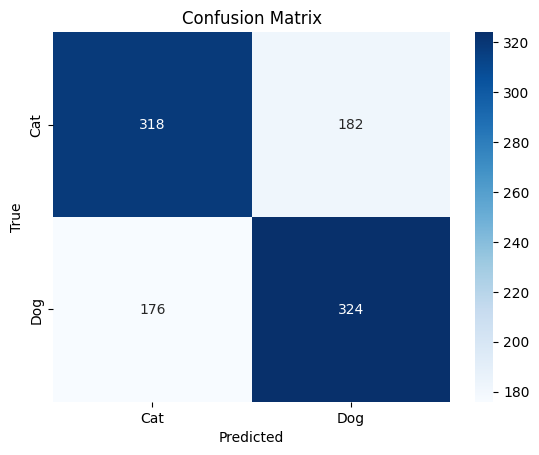

Model saved to C:\Users\User\Desktop\dogs_vs_cats\svm_model.pkl


In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

import os

train_dir = r"C:\Users\User\Desktop\dogs_vs_cats\test"

# Check if the folder exists
if not os.path.exists(train_dir):
    print(f"Error: The directory {train_dir} does not exist!")
else:
    print(f"Directory found: {train_dir}")

# List files in the directory
file_list = os.listdir(train_dir)
if not file_list:
    print("Error: No files found in the directory!")
else:
    print(f"Found {len(file_list)} files in the directory.")
    print("First 5 files:", file_list[:5])  # Print first few files for verification


# Define dataset paths
dataset_dir = r"C:\Users\User\Desktop\dogs_vs_cats"
train_dir = train_dir = os.path.join(dataset_dir, r"C:\Users\User\Desktop\dogs_vs_cats\test")


# Check if the path exists
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"{train_dir} not found. Ensure dataset is extracted correctly.")

# Initialize parameters
image_size = (50, 50)  # Resize images to 50x50
categories = {'cat': 0, 'dog': 1}  # Labels: cat -> 0, dog -> 1

def load_images_from_folder(folder):
    features, labels = [], []
    
    for subfolder in os.listdir(folder):  # Iterate over 'cats' and 'dogs'
        subfolder_path = os.path.join(folder, subfolder)

        # Ensure it's a directory
        if not os.path.isdir(subfolder_path):
            print(f"Skipping non-folder: {subfolder}")
            continue

        for filename in tqdm(os.listdir(subfolder_path), desc=f"Processing {subfolder}"):
            img_path = os.path.join(subfolder_path, filename)

            # Ensure it's an image file
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {filename}")
                continue

            # Determine label
            if subfolder.lower() == 'cats':
                label = categories['cat']
            elif subfolder.lower() == 'dogs':
                label = categories['dog']
            else:
                print(f"Skipping unrecognized folder: {subfolder}")
                continue
            
            # Read and process image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error: Unable to read image {filename}, skipping...")
                continue

            image_resized = cv2.resize(image, image_size)
            image_normalized = image_resized / 255.0
            image_flattened = image_normalized.flatten()

            features.append(image_flattened)
            labels.append(label)
    
    return np.array(features), np.array(labels)




# Load the training images
features, labels = load_images_from_folder(train_dir)

if len(features) == 0:
    raise ValueError("No images found! Check your dataset path and file structure.")

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

# Clear up some memory
del features
del labels

# Define the PCA and SVM pipeline
pca = PCA()  # We'll tune the number of components
svm = SVC()  # Support Vector Classifier

# Create a pipeline
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

# Set up parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': [50, 100, 150],  # Tune the number of components for PCA
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Tune the SVM kernel
    'svm__C': [0.1, 1, 10]  # Regularization parameter for SVM
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)

# Print classification report
target_names = ['Cat', 'Dog']
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save the model
model_file_path = os.path.join(dataset_dir, "svm_model.pkl")
joblib.dump(best_model, model_file_path)
print(f"Model saved to {model_file_path}")
